# Priprema fake news dataset-a

### Importovanje

In [1]:
import pandas as pd
import random
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt


nltk.download('stopwords')
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lukakrickovic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Ucitavanje i spajanje csv fajlova sa dodatim FAKE atributom da se razlikuje izvor

In [2]:
true_df = pd.read_csv('../datasets/fake-news/True.csv')
fake_df = pd.read_csv('../datasets/fake-news/Fake.csv')

true_df = true_df.assign(fake = [False for _ in true_df.iterrows()])
fake_df = fake_df.assign(fake = [True for _ in fake_df.iterrows()])

df = pd.concat([true_df, fake_df])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   fake     44898 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 1.8+ MB


Posto cemo u buducim eksperimentima koristiti samo algoritme koji ne uzimaju ikakve dodatne parametre sem ulaznog teksta, jedino mozemo da se potrudimo da imamo maksimalno izbalansiranu text kolonu.
Ovo mozemo postici posmatranjem subject kolone - disbalans u ovoj koloni moze biti indikator "subjektivnosti" naseg modela
Takodje, ne treba zanemariti cinjenicu da neki tipovi tekstova imaju vecu verovatnocu da budu maliciozni

In [3]:
df['subject'].value_counts(normalize=True)

politicsNews       0.251058
worldnews          0.225957
News               0.201568
politics           0.152368
left-news          0.099314
Government News    0.034968
US_News            0.017440
Middle-east        0.017328
Name: subject, dtype: float64

In [4]:
true_df = df[df['fake'] == True]
fake_df = df[df['fake'] == False]

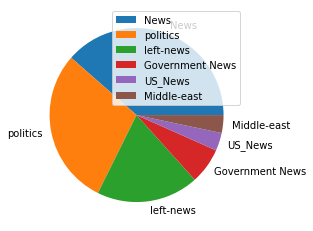

In [5]:
plt.pie(true_df['subject'].value_counts(normalize=True), labels = true_df['subject'].value_counts(normalize=True).keys())
plt.legend()
plt.show()

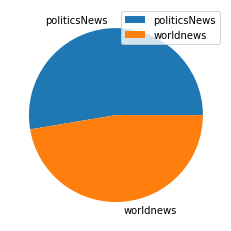

In [6]:
to_plot = fake_df['subject'].value_counts(normalize=True)
plt.pie(to_plot, labels = to_plot.keys())
plt.legend()
plt.show()

Na osnovu ovoga vidimo da su najpopularnije kategorije "politicsNews", "worldNews", "News", "politics" i slicno.
Sve ove teme su medjusobno veoma slicne i definitivno pokazuju prednost politickih tema i odsustvo svih ostalih. Ovakvo stanje ne mozemo ispraviti izbacivanjem redova, ili interpolacijama, nego moramo dodavati redove tako da se poveca raznovrsnost tema.

Kada analiziramo podatke podeljene na true i fake, jaz postaje prilicno naglasen, jer se u fake kategoriji pojavljuju samo politicke i world vesti (vesti o globalnoj politickoj sceni).

In [7]:
# https://www.kaggle.com/datasets/hassanamin/textdb3

new_df = pd.read_csv('../datasets/fake-news/news_articles.csv')
additional_fake_news = new_df[new_df["label"] == "Fake"]['type']
additional_fake_news.value_counts()

bs            601
conspiracy    430
satire        146
junksci       102
fake           15
Name: type, dtype: int64

Vidimo da dodavanjem ovog dataseta dobijamo i 'conspiracy' kategoriju, kao i 'satire', i 'junkscience', odnosno 'junksci'

In [8]:
additional_fake_news = new_df[new_df["label"] == "Fake"]
additional_fake_news = additional_fake_news.rename(columns={"type": "subject"})
# drop all columns except text and subject 
additional_fake_news = additional_fake_news.drop(
    columns=[
        'label',
        'author',
        'published',
        'language',
        'site_url',
        'main_img_url',
        'text_without_stopwords',
        'title_without_stopwords',
        'hasImage' 
        ]
        )

additional_fake_news = additional_fake_news.assign(fake = [True for _ in additional_fake_news.iterrows()])

additional_fake_news.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1294 entries, 33 to 2094
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1294 non-null   object
 1   text     1292 non-null   object
 2   subject  1294 non-null   object
 3   fake     1294 non-null   bool  
dtypes: bool(1), object(3)
memory usage: 41.7+ KB


In [9]:
df = pd.concat([df, additional_fake_news])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46192 entries, 0 to 2094
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    46192 non-null  object
 1   text     46190 non-null  object
 2   subject  46192 non-null  object
 3   date     44898 non-null  object
 4   fake     46192 non-null  bool  
dtypes: bool(1), object(4)
memory usage: 1.8+ MB


In [10]:
print('Raspodela po temama:')
print(df[df['fake'] == True]['subject'].value_counts(normalize=True))
print()
print('poredjenje ukupnog broja redova')
fake_count = df[df['fake'] == True].shape[0]
true_count = df[df['fake'] == False].shape[0]
print(f"fake / true: {fake_count} / {true_count}")
needed_row_count = fake_count - true_count
print(f'Treba da dodamo: {needed_row_count} redova')

Raspodela po temama:
News               0.365288
politics           0.276125
left-news          0.179980
Government News    0.063370
US_News            0.031604
Middle-east        0.031403
bs                 0.024258
conspiracy         0.017356
satire             0.005893
junksci            0.004117
fake               0.000605
Name: subject, dtype: float64

poredjenje ukupnog broja redova
fake / true: 24775 / 21417
Treba da dodamo: 3358 redova


Sada kada smo dodali lazne vesti, moramo da dodamo istinite da bismo ponovo imali balansiran skup podataka

In [11]:
new_true = pd.read_csv('../datasets/fake-news/articles1.csv')
new_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   50000 non-null  int64  
 1   id           50000 non-null  int64  
 2   title        50000 non-null  object 
 3   publication  50000 non-null  object 
 4   author       43694 non-null  object 
 5   date         50000 non-null  object 
 6   year         50000 non-null  float64
 7   month        50000 non-null  float64
 8   url          0 non-null      float64
 9   content      50000 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 3.8+ MB


Na prvi pogled, ovaj dataset nam moze biti veoma koristan za diverzifikaciju realnih vesti, **ali** nema kolonu subject.

Ovo je odlicna prilika da isprobamo LDA za izvlacenje tema iz kolone 'content'

Notebook uz pomoc koje smo ovo odradili je 'lda.ipynb' 

In [12]:
# new_true = new_true.sample(n=needed_row_count)
new_true = new_true.drop(columns=['publication', 'url', 'author', 'date', 'year', 'month', 'Unnamed: 0', 'id'])

# rename content to text in new_true
new_true = new_true.rename(columns={"content": "text"})

# new_true = new_true.drop(columns=['Unnamed: 0'])
new_true.info()
new_true = new_true.assign(fake = [False for _ in new_true.iterrows()])
new_true = new_true.assign(subject = ['various' for _ in new_true.iterrows()])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   50000 non-null  object
 1   text    50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Kako bismo spojili nas novi true dataset sa starim, tako da se zadrzi po 50% i od jednog i od drugog, moracemo ponovo da razdvojimo na true i false dataframe-ove, pa da ih konkateniramo

In [13]:
import numpy as np

true_subset = df[df['fake'] == False]
fake_subset = df[df['fake'] == True]

# Postavljamo da ukupno treba da bude jednak broj true i fake naslova
total_true_count = fake_subset.shape[0] 

drop_indices = np.random.choice(true_subset.shape[0], int(true_subset.shape[0] / 2), replace=False)
true_subset = true_subset.drop(drop_indices)

drop_new_subset_indicies = np.random.choice(new_true.shape[0], new_true.shape[0]+ true_subset.shape[0] - total_true_count, replace=False)
new_true_subset = new_true.drop(drop_new_subset_indicies)

true_subset = pd.concat([true_subset, new_true_subset])
df = pd.concat([true_subset, fake_subset])

In [14]:
df[df['fake'] == False]['subject'].value_counts(normalize=True)

various         0.567750
politicsNews    0.226075
worldnews       0.206176
Name: subject, dtype: float64

Iako smo anotirali sa 'various' u okviru ovog notebooka, znamo iz 'lda.ipynb' da je ovaj dataset prilicno raznolik, te da smo sa 56% dodatih tekstova drasticno povecali raznolikost i izbalansirali ovaj dataset.

Proveravamo jos jednom da su true i fake barem priblizno jednaki po velicinama

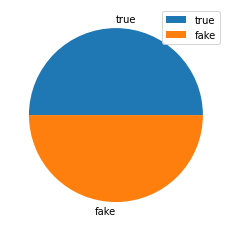

TRUE: 50.0%, FAKE: 50.0%


In [15]:
true_count = df[df['fake'] == False].shape[0]
fake_count = df[df['fake'] == True].shape[0]

plt.pie(np.array([true_count, fake_count]), labels=['true', 'fake'])
plt.legend()
plt.show()
print(f'TRUE: {100 * true_count / (true_count + fake_count)}%, FAKE: {100 * fake_count / (true_count + fake_count)}%')

In [16]:
df.to_csv('../datasets/fake-news/balansed_fake_news_dataset.csv', index=False)